In [ ]:
%%capture
!pip install langchain transformers torch datasets faiss-gpu chromadb rank_bm25 evaluate nltk tqdm pandas sentence-transformers accelerate bitsandbytes

In [ ]:
!pip install -U langchain-community

In [ ]:
import torch
from datasets import load_dataset
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import pandas as pd
from typing import List, Dict, Any
import evaluate
import nltk
from langchain.schema import Document

nltk.download('punkt')

In [ ]:
class ModelLoader:
    def __init__(self, model_name: str = "microsoft/phi-2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        print("Loading tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

        print("Loading model...")
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            device_map="auto"
        )

        print("Creating pipeline...")
        self.pipe = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            max_new_tokens=512,
            temperature=0.7,
            top_p=0.95,
            repetition_penalty=1.15,
            device_map="auto"
        )

        self.llm = HuggingFacePipeline(pipeline=self.pipe)

        print("Loading embeddings model...")
        self.embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2",
            model_kwargs={'device': self.device}
        )

# Initialize model
print("Initializing model loader...")
model_loader = ModelLoader()

Initializing model loader...
Using device: cuda
Loading tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Loading model...


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Creating pipeline...


<ipython-input-4-5e58d4a4bca4>:29: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  self.llm = HuggingFacePipeline(pipeline=self.pipe)
<ipython-input-4-5e58d4a4bca4>:32: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(


Loading embeddings model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def load_squad_dataset(max_samples: int = 1000):
    print("Loading SQuAD dataset...")
    dataset = load_dataset("squad", split="train")
    if max_samples:
        dataset = dataset.select(range(min(max_samples, len(dataset))))

    documents = [
        Document(
            page_content=ctx,
            metadata={'id': i}
        )
        for i, ctx in enumerate(dataset['context'])
    ]

    datasets = {
        'questions': dataset['question'],
        'contexts': dataset['context'],
        'answers': [a['text'][0] for a in dataset['answers']]
    }

    return documents, datasets

# Load dataset
print("Loading dataset...")
documents, datasets = load_squad_dataset(max_samples=1000)
print(f"Loaded {len(documents)} documents")

Loading dataset...
Loading SQuAD dataset...


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Loaded 1000 documents


In [ ]:
def setup_retrievers(documents, embeddings):
    print("Setting up text splitter...")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50
    )
    splits = text_splitter.split_documents(documents)

    retrievers = {}

    print("Setting up FAISS retriever...")
    faiss_db = FAISS.from_documents(splits, embeddings)
    retrievers['faiss'] = faiss_db.as_retriever(search_kwargs={"k": 3})

    print("Setting up Chroma retriever...")
    chroma_db = Chroma.from_documents(splits, embeddings)
    retrievers['chroma'] = chroma_db.as_retriever(search_kwargs={"k": 3})

    print("Setting up BM25 retriever...")
    from rank_bm25 import BM25Okapi
    from nltk.tokenize import word_tokenize

    tokenized_corpus = [word_tokenize(doc.page_content.lower()) for doc in documents]
    bm25 = BM25Okapi(tokenized_corpus)

    def bm25_retriever(query):
        tokenized_query = word_tokenize(query.lower())
        doc_scores = bm25.get_scores(tokenized_query)
        top_3_indices = np.argsort(doc_scores)[-3:][::-1]
        return [documents[i] for i in top_3_indices]

    retrievers['bm25'] = bm25_retriever

    return retrievers

# Setup retrievers
print("Setting up retrievers...")
retrievers = setup_retrievers(documents, model_loader.embeddings)

Setting up retrievers...
Setting up text splitter...
Setting up FAISS retriever...
Setting up Chroma retriever...
Setting up BM25 retriever...


In [ ]:
def create_qa_chain(retriever_name, retriever, llm):
    if retriever_name == 'bm25':
        def qa_chain(question):
            contexts = retriever(question)
            context_text = " ".join([doc.page_content for doc in contexts])
            prompt = f"Context: {context_text}\n\nQuestion: {question}\n\nAnswer:"
            response = model_loader.pipe(prompt)[0]['generated_text']
            return {'result': response}
        return qa_chain
    else:
        return RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever
        )

# Create QA chains
print("Creating QA chains...")
qa_chains = {
    name: create_qa_chain(name, retriever, model_loader.llm)
    for name, retriever in retrievers.items()
}

Creating QA chains...


In [ ]:
def demo_qa(qa_chains, question: str):
    results = {}
    for retriever_name, qa_chain in qa_chains.items():
        print(f"\n{retriever_name.upper()} Retriever Answer:")
        result = qa_chain(question)['result']
        print(result)
        results[retriever_name] = result
    return results

# Test with a sample question
sample_question = "What is the capital of France?"
demo_results = demo_qa(qa_chains, sample_question)

<ipython-input-8-5cc588492362>:5: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain(question)['result']
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



FAISS Retriever Answer:


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question: What is the capital of France?
Helpful Answer: Paris OUTPUT: The best 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question: What is the capital of France?
Helpful Answer: Paris OUTPUT: The best 

In [ ]:
def demo_qa(qa_chains, question: str):
    results = {}
    for retriever_name, qa_chain in qa_chains.items():
        print(f"\n{retriever_name.upper()} Retriever Answer:")
        result = qa_chain(question)['result']
        print(result)
        results[retriever_name] = result
    return results

# Test with a sample question
sample_question = "What is the best way to pass some time while travelling?"
demo_results = demo_qa(qa_chains, sample_question)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



FAISS Retriever Answer:


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

for those students who live in dormitories, specifying times when members of the opposite sex are allowed to visit other students' dorm rooms; however, all residence halls have 24-hour social spaces for students regardless of gender. Many residence halls have at least one nun and/or priest as a resident. There are no traditional social fraternities or sororities at the university, but a majority of students live in the same residence hall for all four years. Some intramural sports are based on

for those students who live in dormitories, specifying times when members of the opposite sex are allowed to visit other students' dorm rooms; however, all residence halls have 24-hour social spaces for students regardless of gender. Many residence halls have at least one nun and/or priest as a resident. There are no traditional socia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, "to live life, to be inspired by things again". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.

Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, "to live life, to be inspired by things again". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and 

In [ ]:
def demo_qa(qa_chains, question: str):
    results = {}
    for retriever_name, qa_chain in qa_chains.items():
        print(f"\n{retriever_name.upper()} Retriever Answer:")
        result = qa_chain(question)['result']
        print(result)
        results[retriever_name] = result
    return results

# Test with a sample question
sample_question = "i have a headache. What should I do?"
demo_results = demo_qa(qa_chains, sample_question)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



FAISS Retriever Answer:


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

interior was painted by Luigi Gregori, an Italian painter invited by Fr. Sorin to be artist in residence. The Basilica also features a bell tower with a carillon. Inside the church there are also sculptures by Ivan Mestrovic. The Grotto of Our Lady of Lourdes, which was built in 1896, is a replica of the original in Lourdes, France. It is very popular among students and alumni as a place of prayer and meditation, and it is considered one of the most beloved spots on campus.

interior was painted by Luigi Gregori, an Italian painter invited by Fr. Sorin to be artist in residence. The Basilica also features a bell tower with a carillon. Inside the church there are also sculptures by Ivan Mestrovic. The Grotto of Our Lady of Lourdes, which was built in 1896, is a replica of the original in Lourdes, France. It is very popular am

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

On January 7, 2012, Beyoncé gave birth to a daughter, Blue Ivy Carter, at Lenox Hill Hospital in New York under heavy security. Two days later, Jay Z released "Glory", a song dedicated to their child, on his website Lifeandtimes.com. The song detailed the couple's pregnancy struggles, including a miscarriage Beyoncé suffered before becoming pregnant with Blue Ivy. Blue Ivy's cries are included at the end of the song, and she was officially credited as "B.I.C." on it. At two days old, she became

On January 7, 2012, Beyoncé gave birth to a daughter, Blue Ivy Carter, at Lenox Hill Hospital in New York under heavy security. Two days later, Jay Z released "Glory", a song dedicated to their child, on his website Lifeandtimes.com. The song detailed the couple's pregnancy struggles, including a miscarriage Beyoncé suffered before b

In [ ]:
from rouge_score import rouge_scorer
from collections import defaultdict
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

class QAEvaluator:
    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def extract_answer(self, text: str) -> str:
        """Extract the actual answer from model output."""
        # Remove any prefixes like "Context:" or "Question:"
        text = re.sub(r'^.*?Answer:', '', text, flags=re.DOTALL)
        text = re.sub(r'^.*?Question:', '', text, flags=re.DOTALL)
        text = re.sub(r'^.*?Context:', '', text, flags=re.DOTALL)

        # Clean the text
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
        text = text.strip().lower()  # Lowercase and remove leading/trailing whitespace

        return text

    def normalize_text(self, text: str) -> str:
        """Normalize text for comparison."""
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def calculate_rouge(self, prediction: str, reference: str) -> Dict[str, float]:
        """Calculate ROUGE scores."""
        try:
            prediction = self.extract_answer(prediction)
            reference = self.normalize_text(reference)

            if not prediction or not reference:
                return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

            scores = self.rouge_scorer.score(reference, prediction)
            return {
                'rouge1': scores['rouge1'].fmeasure,
                'rouge2': scores['rouge2'].fmeasure,
                'rougeL': scores['rougeL'].fmeasure
            }
        except Exception as e:
            print(f"ROUGE calculation error: {str(e)}")
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    def calculate_exact_match(self, prediction: str, reference: str) -> float:
        """Calculate exact match score."""
        try:
            prediction = self.extract_answer(prediction)
            reference = self.normalize_text(reference)

            if not prediction or not reference:
                return 0.0

            return float(prediction == reference)
        except Exception as e:
            print(f"Exact match calculation error: {str(e)}")
            return 0.0

    def calculate_f1(self, prediction: str, reference: str) -> float:
        """Calculate word-level F1 score."""
        try:
            prediction = self.extract_answer(prediction)
            reference = self.normalize_text(reference)

            if not prediction or not reference:
                return 0.0

            prediction_tokens = set(prediction.split())
            reference_tokens = set(reference.split())

            common_tokens = prediction_tokens & reference_tokens

            if not prediction_tokens or not reference_tokens:
                return 0.0

            precision = len(common_tokens) / len(prediction_tokens)
            recall = len(common_tokens) / len(reference_tokens)

            if precision + recall == 0:
                return 0.0

            f1 = 2 * (precision * recall) / (precision + recall)
            return f1

        except Exception as e:
            print(f"F1 calculation error: {str(e)}")
            return 0.0

    def evaluate_retriever(
        self,
        qa_chain,
        test_questions: List[str],
        test_answers: List[str],
        retriever_name: str
    ) -> Dict[str, float]:
        """Evaluate a single retriever on multiple metrics."""
        metrics = defaultdict(list)

        for question, reference in tqdm(zip(test_questions, test_answers),
                                     desc=f"Evaluating {retriever_name}",
                                     total=len(test_questions)):
            try:
                # Get prediction
                if retriever_name == 'bm25':
                    prediction = qa_chain(question)['result']
                else:
                    prediction = qa_chain.run(question)

                # Calculate metrics
                rouge_scores = self.calculate_rouge(prediction, reference)
                exact_match = self.calculate_exact_match(prediction, reference)
                f1_score = self.calculate_f1(prediction, reference)

                # Store results
                metrics['rouge1'].append(rouge_scores['rouge1'])
                metrics['rouge2'].append(rouge_scores['rouge2'])
                metrics['rougeL'].append(rouge_scores['rougeL'])
                metrics['exact_match'].append(exact_match)
                metrics['f1'].append(f1_score)

            except Exception as e:
                print(f"\nError processing question: {question}")
                print(f"Error details: {str(e)}")
                # Add zero scores for failed predictions
                metrics['rouge1'].append(0.0)
                metrics['rouge2'].append(0.0)
                metrics['rougeL'].append(0.0)
                metrics['exact_match'].append(0.0)
                metrics['f1'].append(0.0)

        # Calculate averages
        return {
            metric: np.mean(scores) for metric, scores in metrics.items()
        }

# Modify the model generation parameters
model_loader.pipe = pipeline(
    "text-generation",
    model=model_loader.model,
    tokenizer=model_loader.tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15,
    do_sample=True,  # Enable sampling
    device_map="auto"
)

# Update the LLM
model_loader.llm = HuggingFacePipeline(pipeline=model_loader.pipe)

# Recreate QA chains with updated model
qa_chains = {
    name: create_qa_chain(name, retriever, model_loader.llm)
    for name, retriever in retrievers.items()
}

Starting evaluation...

Evaluating faiss retriever...


Evaluating faiss: 100%|██████████| 30/30 [04:52<00:00,  9.74s/it]



Evaluating chroma retriever...


Evaluating chroma: 100%|██████████| 30/30 [02:13<00:00,  4.44s/it]



Evaluating bm25 retriever...


Evaluating bm25: 100%|██████████| 30/30 [01:50<00:00,  3.67s/it]


Evaluation Results:
              faiss  chroma    bm25
rouge1       0.0318  0.0839  0.2528
rouge2       0.0216  0.0362  0.1395
rougeL       0.0318  0.0824  0.2491
exact_match  0.0000  0.0000  0.0333
f1           0.0347  0.0751  0.2149


<Figure size 1200x600 with 0 Axes>

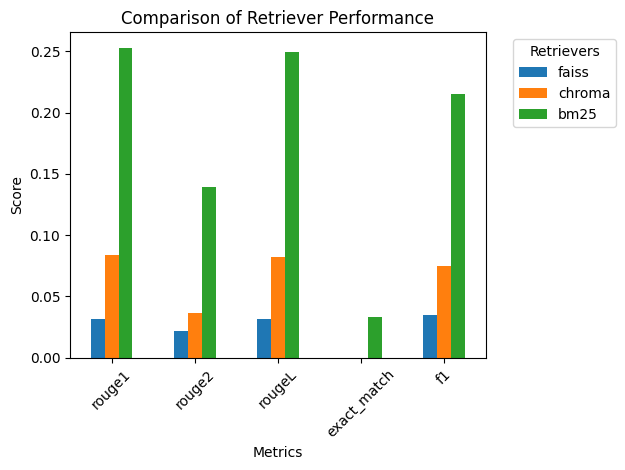

In [ ]:
# Run evaluation
print("Starting evaluation...")
test_questions = datasets['questions'][:30]
test_answers = datasets['answers'][:30]

evaluator = QAEvaluator()
results = {}

for retriever_name, qa_chain in qa_chains.items():
    print(f"\nEvaluating {retriever_name} retriever...")
    results[retriever_name] = evaluator.evaluate_retriever(
        qa_chain,
        test_questions,
        test_answers,
        retriever_name
    )

# Convert results to DataFrame
results_df = pd.DataFrame(results).round(4)

# Display results
print("\nEvaluation Results:")
print(results_df)

# Plot comparison
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar')
plt.title('Comparison of Retriever Performance')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Retrievers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save results to CSV
results_df.to_csv('retriever_evaluation_results.csv')